In [1]:
import os
import os.path
# Set the current file's directory as the default directory
os.chdir('QPGWR/model')

In [2]:
import QPGWR
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import sklearn
from mgwr.gwr import GWR,MGWR
from mgwr.sel_bw import Sel_BW

In [3]:
# raw simulation data
subplot_data=pd.read_csv('../data/raw_sim_data.csv')
cell_data=pd.read_csv('../data/cell_level_data.csv')

## Estimation on subplot-level

In [ ]:
########################################################
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

Important_para=np.zeros([1440,7,500])

from tqdm import tqdm
# estimated parameters of three models based on the plot-level data
#loop for each file to record the estimated parameters of three models
for file_num in tqdm(range(1,501)):
    
    # data=rawdata[rawdata['sim']==(file_num)]
    data=subplot_data[subplot_data['sim']==(file_num)].copy()

    #MGWR functions
    y = data['yield'].values
    X = data[['N','N2']].values
    u = data['X']
    v = data['Y']
    coords = list(zip(u,v))
    y = y.reshape(-1,1)

    file_num=file_num-1
    #x0, a, y0
    xy=np.array(data[['X','Y']])
    gwr_results = GWR(coords, y, X, bw=50, fixed=False,kernel='gaussian').fit()
    
    Important_para[:,0,file_num]=gwr_results.params[:,1]
    Important_para[:,1,file_num]=gwr_results.params[:,2]

    popt0=[data['yield'].min(),(data['yield'].max()-data['yield'].min())/(data['N'].max()-data['N'].min()),data['N'].mean()]
    data_LP=QPGWR.LPGWR(data,50,xy,popt0,n_var='N',y_var='yield')
    
    Important_para[:,2,file_num]=data_LP['NK_']

    popt0=[data['N'].mean(),-(data['yield'].max()-data['yield'].min())/(data['N'].mean()-data['N'].min())**2,data['yield'].max()]
    data_QP=QPGWR.QPGWR(data,50,xy,popt0,n_var='N',y_var='yield')

    data_gpd=gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.X, data.Y))
    
    Important_para[:,3,file_num]=data_QP['b1_']
    Important_para[:,4,file_num]=data_QP['b2_']

    #also record the real eonr
    Important_para[:,5,file_num]=data['b1']
    Important_para[:,6,file_num]=data['b2']

In [ ]:
# np.save('../data/Important_para.npy',Important_para)

## Relative Profit, Bias and RMSE on cell level

In [3]:
# read the results
Important_para=np.load('../Results3th/Important_para.npy')

In [5]:
import sklearn
from sklearn.metrics import mean_squared_error

def NetR(a,x0,y0,EONR,pC,pN):#calculate the net return
    return ((y0 + a * ( EONR - x0 )**2 * (EONR < x0))*pC-pN*EONR)

#set the boundary of eonr
def Nboud(EONR,vmin,vmax):
    EONR[EONR<vmin]=vmin
    EONR[EONR>vmax]=vmax
    return EONR

Bias_benifits=np.zeros([500,3,3])
bias_list=np.zeros([500,3,3])
rms_list=np.zeros([500,3,3])

EONR_list=np.zeros([1440*6,500])
EONRqp_list=np.zeros([1440*6,500])
EONRlp_list=np.zeros([1440*6,500])
EONRq_list=np.zeros([1440*6,500])

# set price for corn
pC=0.17
# pN=pr*pC
for file_num in range(1,501):
    
    #align the cell data with subplot data
    subplot_field=subplot_data[subplot_data['sim']==file_num].copy()
    cell_field=cell_data[cell_data['sim']==file_num].copy()
    cell_field2=subplot_field.merge(cell_field,on=['aunit_id'],how='left')
    
    # cell-level true data
    b0=cell_field2['b0_y'].values
    b1=cell_field2['b1_y'].values
    b2=cell_field2['b2_y'].values

    file_num-=1
    #Raw income: Nk; b0,b1,b2
    vmin=subplot_field['N'].min()
    vmax=subplot_field['N'].max()

    x0=-b1/(2*b2)
    y0=(4*b2*b0-b1**2)/(4*b2)
    a=b2
    
    count=-1
    for pr in [4.16, 6.56, 10.35]:
        #calculate the price of nitrogen based on the price ratio
        pN=pr*pC
        
        count+=1
        EONR=(pr-b1)/2/b2
        T_S=NetR(a,x0,y0,EONR,pC,pN)

        #for Q-GWR
        EONR_q=(pr-Important_para[:,0,file_num])/2/Important_para[:,1,file_num]
        EONR_q=np.repeat(EONR_q, 6)
        EONR_q=Nboud(EONR_q,vmin,vmax)

        T_=NetR(a,x0,y0,EONR_q,pC,pN)-T_S
        Bias_benifits[file_num,count,0]=T_.mean()

        #for LP-GWR
        EONR_lp=Important_para[:,2,file_num]
        EONR_lp=np.repeat(EONR_lp, 6)
        EONR_lp=Nboud(EONR_lp,vmin,vmax)

        T_=NetR(a,x0,y0,EONR_lp,pC,pN)-T_S
        Bias_benifits[file_num,count,1]=T_.mean()

        #for QP-GWR
        EONR_qp=(pr-Important_para[:,3,file_num])/2/Important_para[:,4,file_num]
        EONR_qp=np.repeat(EONR_qp, 6)
        EONR_qp=Nboud(EONR_qp,vmin,vmax)
        EONRqp_list[:,file_num]=EONR_qp

        T_=NetR(a,x0,y0,EONR_qp,pC,pN)-T_S
        Bias_benifits[file_num,count,2]=T_.mean()

        #record the results
        EONR_list[:,file_num]=EONR
        EONRq_list[:,file_num]=EONR_q
        EONRlp_list[:,file_num]=EONR_lp
        EONRqp_list[:,file_num]=EONR_qp

        #evaluate the results
        bias_list[file_num,count,0]=np.mean(EONR_q-EONR)
        rms_list[file_num,count,0] = mean_squared_error(EONR, EONR_q, squared=False)

        bias_list[file_num,count,1]=np.mean(EONR_lp-EONR)
        rms_list[file_num,count,1] = mean_squared_error(EONR, EONR_lp, squared=False)
        
        bias_list[file_num,count,2]=np.mean(EONR_qp-EONR)
        rms_list[file_num,count,2] = mean_squared_error(EONR, EONR_qp, squared=False)

## Plots

Text(0.5, 1.0, 'QP-GWR')

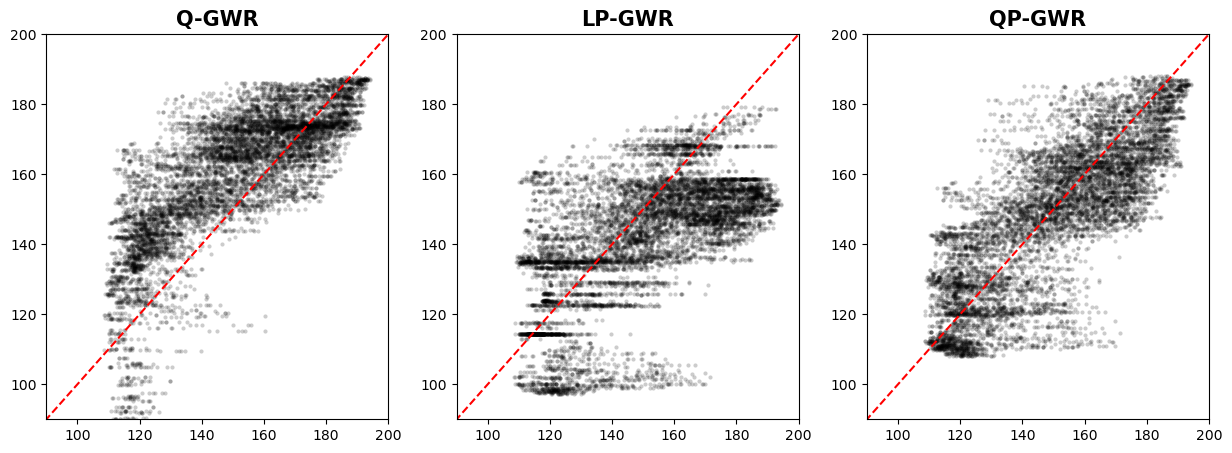

In [6]:
idx=70
# subplot 3
fig, axes = plt.subplots(1,3,figsize=(15,5))
axes[0].plot(EONR_list[:,idx],EONRq_list[:,idx],'k.',alpha=0.2, mec='none')
axes[0].plot([80,240],[80,240],'r--')
axes[0].set_xlim([90,200])
axes[0].set_ylim([90,200])
axes[0].set_title('Q-GWR',fontsize=15,fontweight='bold')

axes[1].plot(EONR_list[:,idx],EONRlp_list[:,idx],'k.',alpha=0.2, mec='none')
axes[1].plot([80,240],[80,240],'r--')
axes[1].set_xlim([90,200])
axes[1].set_ylim([90,200])
axes[1].set_title('LP-GWR',fontsize=15,fontweight='bold')

axes[2].plot(EONR_list[:,idx],EONRqp_list[:,idx],'k.',alpha=0.2, mec='none')
axes[2].plot([80,240],[80,240],'r--')
axes[2].set_xlim([90,200])
axes[2].set_ylim([90,200])
axes[2].set_title('QP-GWR',fontsize=15,fontweight='bold')

In [7]:
fig.savefig('../figs/fig5.png',dpi=600)

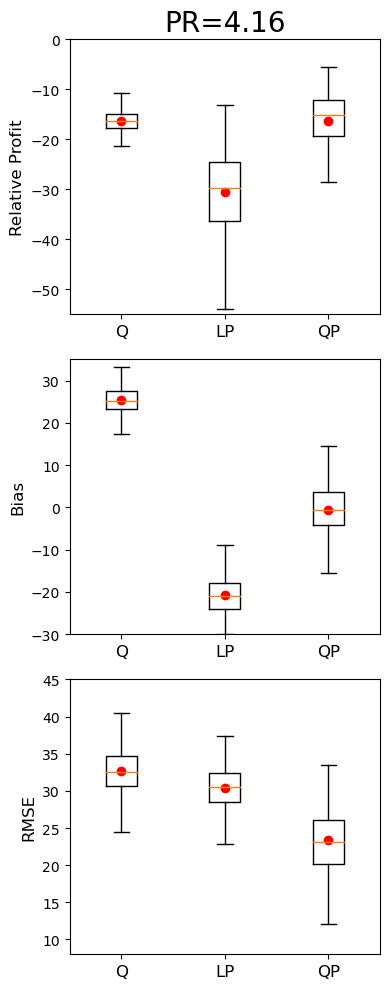

In [14]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6/1.5, 15/1.5))

labels = ['Q','LP','QP']

for i, data_list in enumerate([Bias_benifits, bias_list, rms_list]):
    pltdata = [data_list[:,0,0], data_list[:,0,1], data_list[:,0,2]]
    axes[i].boxplot(pltdata, showfliers=False)

    # Calculate means
    means = [np.mean(data) for data in pltdata]

    # Add mean values to the boxplots
    for j, mean in enumerate(means, start=1):
        axes[i].scatter(j, mean, color='red')

    axes[i].set_xticklabels(labels, fontsize=12)

axes[0].set_title('PR=4.16', fontsize=20)
axes[0].set_ylim([-55, 0])
axes[0].set_ylabel('Relative Profit', fontsize=12)
axes[1].set_ylim([-30, 35])
axes[1].set_ylabel('Bias', fontsize=12)
axes[2].set_ylim([8, 45])
axes[2].set_ylabel('RMSE', fontsize=12)

plt.tight_layout()

In [15]:
fig.savefig('../figs/fig4a.png',dpi=300)

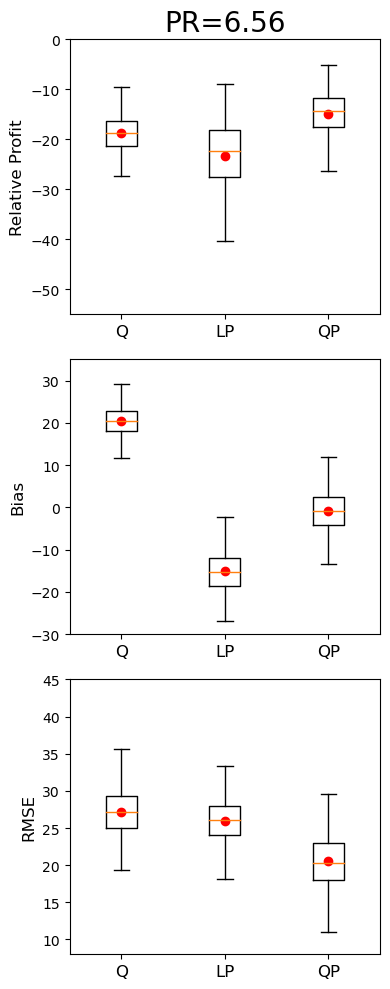

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6/1.5, 15/1.5))

labels = ['Q','LP','QP']

for i, data_list in enumerate([Bias_benifits, bias_list, rms_list]):
    pltdata = [data_list[:,1,0], data_list[:,1,1], data_list[:,1,2]]
    axes[i].boxplot(pltdata, showfliers=False)

    # Calculate means
    means = [np.mean(data) for data in pltdata]

    # Add mean values to the boxplots
    for j, mean in enumerate(means, start=1):
        axes[i].scatter(j, mean, color='red')

    axes[i].set_xticklabels(labels, fontsize=12)

axes[0].set_title('PR=6.56', fontsize=20)
axes[0].set_ylim([-55, 0])
axes[0].set_ylabel('Relative Profit', fontsize=12)
axes[1].set_ylim([-30, 35])
axes[1].set_ylabel('Bias', fontsize=12)
axes[2].set_ylim([8, 45])
axes[2].set_ylabel('RMSE', fontsize=12)

plt.tight_layout()

In [17]:
fig.savefig('../figs/fig4b.png',dpi=300)

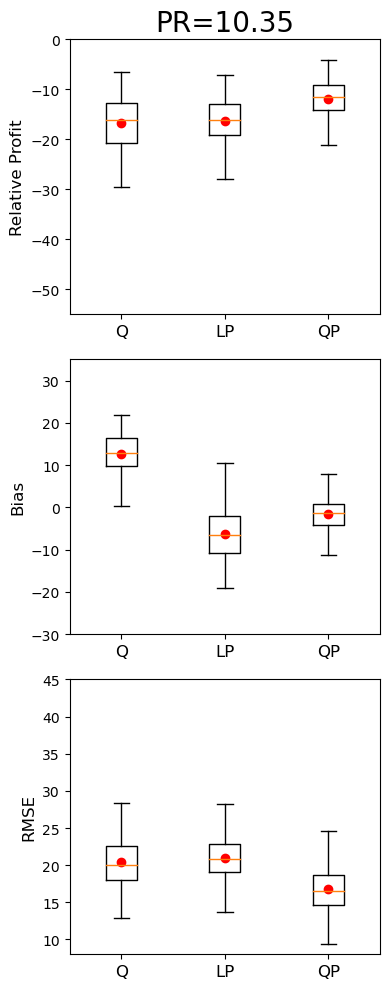

In [18]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6/1.5, 15/1.5))

labels = ['Q','LP','QP']

for i, data_list in enumerate([Bias_benifits, bias_list, rms_list]):
    pltdata = [data_list[:,2,0], data_list[:,2,1], data_list[:,2,2]]
    axes[i].boxplot(pltdata, showfliers=False)

    # Calculate means
    means = [np.mean(data) for data in pltdata]

    # Add mean values to the boxplots
    for j, mean in enumerate(means, start=1):
        axes[i].scatter(j, mean, color='red')

    axes[i].set_xticklabels(labels, fontsize=12)

axes[0].set_title('PR=10.35', fontsize=20)
axes[0].set_ylim([-55, 0])
axes[0].set_ylabel('Relative Profit', fontsize=12)
axes[1].set_ylim([-30, 35])
axes[1].set_ylabel('Bias', fontsize=12)
axes[2].set_ylim([8, 45])
axes[2].set_ylabel('RMSE', fontsize=12)

plt.tight_layout()

In [19]:
fig.savefig('../figs/fig4c.png',dpi=300)

In [23]:
# summary mean for the three models
print(np.mean(Bias_benifits, axis=0))
print(np.mean(bias_list, axis=0))
print(np.mean(rms_list, axis=0))

[[-16.33957156 -30.5798733  -16.27809984]
 [-18.76343553 -23.29195649 -15.03633389]
 [-16.79440418 -16.40462006 -11.93195624]]
[[ 25.32655276 -20.64363291  -0.53402521]
 [ 20.32046962 -15.08144948  -0.93349719]
 [ 12.55995841  -6.29783481  -1.52542641]]
[[32.71670559 30.35611982 23.41198974]
 [27.18867131 25.99244624 20.5636545 ]
 [20.42282239 20.97799636 16.76610594]]
